# UE 10

In [1]:
#Import Packages
from gurobipy import *
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

## Modell Kraftwerkseinsatz


#### Grundlegende Parameter der Kraftwerke und der Nachfrage

In [2]:
#Definition der Parameter des Modells
#Nachfrage
load_min = 85
load_max = 170
#Leistung der Kraftwerke
Pmax_kw1 = 100 #Leistung in MW
Pmin_kw1 = 25 #Leistung in MW
Pmax_kw2 = 50 #Leistung in MW
Pmin_kw2 = 15 #Leistung in MW

#Kosten der Kraftwerke
fk_kw1 = 150 #fixe Kosten in €
fk_kw2 = 125 #fixe Kosten in €

vk_kw1 = 60 #variable Kosten in €/Mwh
vk_kw2 = 80 #variable Kosten in €/Mwh

#### Zusätzliches berücksichtigen von Kraftwerksemissionen

In [3]:
#Einfügen von Emissionen (https://www.volker-quaschning.de/datserv/CO2-spez/index.php)
#Annahme: Ein Steinkohle und ein Gaskraftwerk
e_faktor_kw1 = 80 #in t CO2 je MWh
e_faktor_kw2 = 20 #in t CO2 je MWh
e_limit = 35000 #in t CO2
#CO2-Kosten für Zertifikate
e_kosten = 24.4 #in €/t CO2

#### Erweiterung auf mehrere Perioden mittels der Nachfrage

In [4]:
#Definition der Parameter des Modells für Periode 2-5
#Nachfrage
load_min_t2 = 125
load_min_t3 = 110
load_min_t4 = 90
load_min_t5 = 145

### Anlegen des Modells

In [6]:
#Create Model
M = Model('Kraftwerkseinsatz')

### Add Variables

In [7]:
# Definition der Variablen
# start with KW1
x1 = M.addVar(vtype=GRB.CONTINUOUS, name="Kraftwerkseinsatz KW 1 in t1")
x1_t2 = M.addVar(vtype=GRB.CONTINUOUS, name="Kraftwerkseinsatz KW 1 in t2")
x1_t3 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 1 in t3")
x1_t4 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 1 in t4")
x1_t5 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 1 in t5")

# continue with KW2
x2 = M.addVar(vtype=GRB.CONTINUOUS, name="Kraftwerkseinsatz KW 2 in t1")
x2_t2 = M.addVar(vtype=GRB.CONTINUOUS, name="Kraftwerkseinsatz KW 2 in t2")
x2_t3 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 2 in t3")
x2_t4 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 2 in t4")
x2_t5 = M.addVar(vtype=GRB.CONTINUOUS, name = "Kraftwerkseinsatz KW 2 in t5")

#### Zusätzliches berücksichtigen von Kraftwerksemissionen

In [8]:
#Variablen für die Emissionen
#Gesamt-CO2-emissionen
E_total = M.addVar(vtype=GRB.CONTINUOUS, name = "Gesamtemissionen")
#CO2 Emissionen von Kraftwerk 1 in Periode 1-5
E_x1_t1 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW1 in t1")
E_x1_t2 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW1 in t2")
E_x1_t3 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW1 in t3")
E_x1_t4 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW1 in t4")
E_x1_t5 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW1 in t5")
#CO2 Emissionen von Kraftwerk 2 in Periode 1-5
E_x2_t1 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW2 in t1")
E_x2_t2 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW2 in t2")
E_x2_t3 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW2 in t3")
E_x2_t4 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW2 in t4")
E_x2_t5 = M.addVar(vtype=GRB.CONTINUOUS, name = "Emissionen des KW2 in t5")

### Add Constraints

In [9]:
#Definition der Nebenbedingungen

#Minimale Leistung der Krafwerke
c1 = M.addConstr(x1>=Pmin_kw1, "Minimum KW1")
c2 = M.addConstr(x2>=Pmin_kw2, "Minimum KW2")

#Maximale Leistung der Krafwerke
c3 = M.addConstr(x1<=Pmax_kw1, "Maximum KW1")
c4 = M.addConstr(x2<=Pmax_kw2, "Maximum KW2")

#Nachfrage
c5 = M.addConstr(x1+x2<=load_max, "Maximum gesamt")
c6 = M.addConstr(x1+x2>=load_min, "Minimum gesamt")

#Nichtnegativität
c7 = M.addConstr(x1>=0, "Nichtnegativität")
c8 = M.addConstr(x2>=0, "Nichtnegativität")

In [10]:
#Definition der Nebenbedingungen für Periode 2
#minimale Krafwerksleistung muss erfüllt sein
c1_t2 = M.addConstr(x1_t2 >= Pmin_kw1, "Minimum KW 1")
c2_t2 = M.addConstr(x2_t2 >= Pmin_kw2, "Minimum KW 2")
#maximale Kraftwerksleistung darf nicht überschritten werden
c3_t2 = M.addConstr(x1_t2 <= Pmax_kw1, "Maximum KW 1")
c4_t2 = M.addConstr(x2_t2 <= Pmax_kw2, "Maximum KW 2")
#Nachfrage in Periode 2
c5_t2 = M.addConstr(x1_t2+x2_t2 <=load_max, "Maximale Nachfrage")
c6_t2 = M.addConstr(x1_t2+x2_t2 >=load_min_t2, "Minimale Nachfrage")
#Nebenbedingungen für Periode 3
#minimale Krafwerksleistung muss erfüllt sein
c1_t3 = M.addConstr(x1_t3 >= Pmin_kw1, "Minimum KW 1")
c2_t3 = M.addConstr(x2_t3 >= Pmin_kw2, "Minimum KW 2")
#maximale Kraftwerksleistung darf nicht überschritten werden
c3_t3 = M.addConstr(x1_t3 <= Pmax_kw1, "Maximum KW 1")
c4_t3 = M.addConstr(x2_t3 <= Pmax_kw2, "Maximum KW 2")
#Nachfrage in Periode 2
c5_t3 = M.addConstr(x1_t3+x2_t3 <=load_max, "Maximale Nachfrage")
c6_t3 = M.addConstr(x1_t3+x2_t3 >=load_min_t3, "Minimale Nachfrage")
#Nebenbedingungen für Periode 3
#minimale Krafwerksleistung muss erfüllt sein
c1_t4 = M.addConstr(x1_t4 >= Pmin_kw1, "Minimum KW 1")
c2_t4 = M.addConstr(x2_t4 >= Pmin_kw2, "Minimum KW 2")
#maximale Kraftwerksleistung darf nicht überschritten werden
c3_t4 = M.addConstr(x1_t4 <= Pmax_kw1, "Maximum KW 1")
c4_t4 = M.addConstr(x2_t4 <= Pmax_kw2, "Maximum KW 2")
#Nachfrage in Periode 2
c5_t4 = M.addConstr(x1_t4+x2_t4 <=load_max, "Maximale Nachfrage")
c6_t4 = M.addConstr(x1_t4+x2_t4 >=load_min_t4, "Minimale Nachfrage")
#Nebenbedingungen für Periode 4
#minimale Krafwerksleistung muss erfüllt sein
c1_t5 = M.addConstr(x1_t5 >= Pmin_kw1, "Minimum KW 1")
c2_t5 = M.addConstr(x2_t5 >= Pmin_kw2, "Minimum KW 2")
#maximale Kraftwerksleistung darf nicht überschritten werden
c3_t5 = M.addConstr(x1_t5 <= Pmax_kw1, "Maximum KW 1")
c4_t5 = M.addConstr(x2_t5 <= Pmax_kw2, "Maximum KW 2")
#Nachfrage in Periode 5
c5_t5 = M.addConstr(x1_t5+x2_t5 <=load_max, "Maximale Nachfrage")
c6_t5 = M.addConstr(x1_t5+x2_t5 >=load_min_t5, "Minimale Nachfrage")

#### Emissionslimit einführen

In [11]:
e1 = M.addConstr(E_total <= e_limit, "Emissionslimit ist einzuhalten")
e2 = M.addConstr(E_x1_t1 == x1*e_faktor_kw1, "Emissionen vn KW1 in Periode 1")
e3 = M.addConstr(E_x1_t2 == x1_t2*e_faktor_kw1, "Emissionen vn KW1 in Periode 2")
e4 = M.addConstr(E_x1_t3 == x1_t3*e_faktor_kw1, "Emissionen vn KW1 in Periode 3")
e5 = M.addConstr(E_x1_t4 == x1_t4*e_faktor_kw1, "Emissionen vn KW1 in Periode 4")
e6 = M.addConstr(E_x1_t5 == x1_t5*e_faktor_kw1, "Emissionen vn KW1 in Periode 5")

e7 = M.addConstr(E_x2_t1 == x2*e_faktor_kw2, "Emissionen vn KW2 in Periode 1")
e8 = M.addConstr(E_x2_t2 == x2_t2*e_faktor_kw2, "Emissionen vn KW2 in Periode 2")
e9 = M.addConstr(E_x2_t3 == x2_t3*e_faktor_kw2, "Emissionen vn KW2 in Periode 3")
e10 = M.addConstr(E_x2_t4 == x2_t4*e_faktor_kw2, "Emissionen vn KW2 in Periode 4")
e11 = M.addConstr(E_x2_t5 == x2_t5*e_faktor_kw2, "Emissionen vn KW2 in Periode 5")

e12 = M.addConstr(E_total == E_x1_t1+E_x1_t2+E_x1_t3+E_x1_t4+
                 E_x1_t5+E_x2_t1+E_x2_t2+E_x2_t3+E_x2_t4+E_x2_t5,"Berechnung Gesamtemissionen")

### Set Objective

In [12]:
#Aufstellen der Zielfunktion
#Minimierung der Kosten
#Option A) Einperiodige Betrachtung ohne CO2-Emissionen
# M.setObjective(fk_kw1+vk_kw1*x1+fk_kw2+vk_kw2*x2, GRB.MINIMIZE)
#Option B) Betrachtung über fünf Perioden
M.setObjective(fk_kw1+vk_kw1*(x1+x1_t2+x1_t3+x1_t4+x1_t5)+
              fk_kw2+vk_kw2*(x2+x2_t2+x2_t3+x2_t4+x2_t5)+
# Zusätzliche Berücksichtigung der CO2-Emissionen               
              E_total*e_kosten, GRB.MINIMIZE)

### Modell optimieren

In [13]:
M.optimize()

Optimize a model with 44 rows, 21 columns and 74 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+04]
Presolve removed 38 rows and 10 columns
Presolve time: 0.01s
Presolved: 6 rows, 11 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7857914e+05   1.353856e+02   0.000000e+00      0s
       6    7.5593500e+05   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds
Optimal objective  7.559350000e+05


### Ergebnisse auslesen


In [14]:
#Attribute verschieden von Null ausgeben lassen
M.printAttr('X')


    Variable            X 
-------------------------
Kraftwerkseinsatz KW 1 in t1           35 
Kraftwerkseinsatz KW 1 in t2           75 
Kraftwerkseinsatz KW 1 in t3           60 
Kraftwerkseinsatz KW 1 in t4           40 
Kraftwerkseinsatz KW 1 in t5           95 
Kraftwerkseinsatz KW 2 in t1           50 
Kraftwerkseinsatz KW 2 in t2           50 
Kraftwerkseinsatz KW 2 in t3           50 
Kraftwerkseinsatz KW 2 in t4           50 
Kraftwerkseinsatz KW 2 in t5           50 
Gesamtemissionen        29400 
Emissionen des KW1 in t1         2800 
Emissionen des KW1 in t2         6000 
Emissionen des KW1 in t3         4800 
Emissionen des KW1 in t4         3200 
Emissionen des KW1 in t5         7600 
Emissionen des KW2 in t1         1000 
Emissionen des KW2 in t2         1000 
Emissionen des KW2 in t3         1000 
Emissionen des KW2 in t4         1000 
Emissionen des KW2 in t5         1000 


In [15]:
## get results from Optimization
values = []
names = []
# objVal = M.objVal

for v in M.getVars():
    values.append(v.X)
    names.append(v.VarName)
# return values, objVal
results = dict(zip(names, values))

In [16]:
# set dataframe for results
ppusage_df = pd.DataFrame(index=np.arange(0,5,1), columns=['usage KW 1', 'usage KW 2'], data={'usage KW 1':values[:5],
                                                                                              'usage KW 2':values[5:10]
                                                                                             }
                         )

emissions_df = pd.DataFrame(index=np.arange(0,5,1), columns=['emissions KW 1', 'emissions KW 2'], data={'emissions KW 1':values[11:16],
                                                                                                        'emissions KW 2':values[16:]
                                                                                                       }
                           )

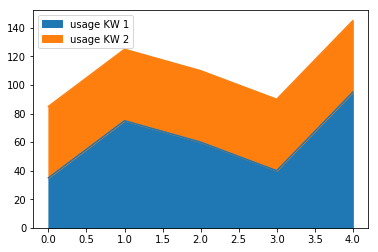

In [17]:
# visualize results, start with PP usage
ppusage_df.plot.area(stacked=True)
plt.show()

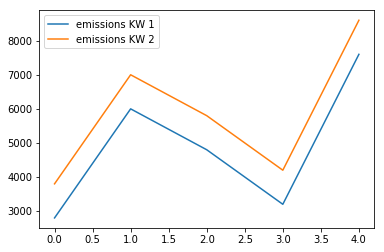

In [18]:
# visualize results, continue with emissions
emissions_df.plot(stacked=True)
plt.show()